In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
import lightgbm as lgbm
import gc

from sklearn.linear_model import Lasso, ElasticNet, RANSACRegressor, Ridge
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,GradientBoostingClassifier,ExtraTreesClassifier
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor,GradientBoostingRegressor,ExtraTreesRegressor
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.svm import LinearSVR,SVR
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.cross_validation import KFold
from sklearn.metrics import mean_absolute_error
from sklearn import preprocessing
from sklearn.model_selection import StratifiedKFold
from itertools import product

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
%matplotlib inline

import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import Imputer

### seaborn에서 한글 나오게하기
sns.set(font="New Gulim")

# import zipfile
# import stacking
#import stackingZillow
#import catboost

C:\ProgramData\Anaconda3\envs\myvenv\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [4]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, BatchNormalization, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


# Load Data

In [5]:
train_2016 = pd.read_csv('input/train_2016_v2.csv')
train_2017 = pd.read_csv('input/train_2017.csv')

prop_2016 = pd.read_csv('input/properties_2016.csv')
prop_2017 = pd.read_csv('input/properties_2017.csv')

sample = pd.read_csv('input/sample_submission.csv')

C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (49) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### 2016 데이터와 2017 데이터 Merge

In [6]:
duplicate_parcelid = list(set(train_2016['parcelid'].unique()).intersection(set(train_2017['parcelid'].unique())))
duplicate_parcelid = pd.DataFrame(duplicate_parcelid,columns=['parcelid'])
duplicate_parcelid.shape

(2354, 1)

In [7]:
df_train_2016 = train_2016.merge(prop_2016, how='left', on='parcelid')
df_train_2017 = train_2017.merge(prop_2017, how='left', on='parcelid')
df_train_2016 = df_train_2016.loc[~df_train_2016['parcelid'].isin(duplicate_parcelid['parcelid'].values)]

In [8]:
df_train = pd.concat([df_train_2016,df_train_2017]).reset_index(drop=True)

In [10]:
del df_train_2016,df_train_2017
gc.collect()

28

# PreProcessing

In [9]:
sample['parcelid'] = sample['ParcelId']
df_test = sample.merge(prop_2017, on='parcelid', how='left')

In [11]:
del prop_2016,prop_2017
gc.collect()

14

In [12]:
df_train.loc[df_train['hashottuborspa'].isnull(),'hashottuborspa'] = False
df_test.loc[df_test['hashottuborspa'].isnull(),'hashottuborspa'] = False

df_train.loc[df_train['taxdelinquencyflag'].isnull(),'taxdelinquencyflag'] = 'N'
df_test.loc[df_test['taxdelinquencyflag'].isnull(),'taxdelinquencyflag'] = 'N'

df_train.loc[df_train['fireplaceflag'].isnull(),'fireplaceflag'] = False
df_test.loc[df_test['fireplaceflag'].isnull(),'fireplaceflag'] = False

df_train['transactiondate_month'] = pd.to_datetime(df_train['transactiondate']).dt.month
df_train['transactiondate_year'] = pd.to_datetime(df_train['transactiondate']).dt.year
#df_train['month_bedrooms'] = df_train['bedroomcnt'] * df_train['transactiondate_month']

df_train["N-location"] = df_train["latitude"] + df_train["longitude"]
df_test["N-location"] = df_test["latitude"] + df_test["longitude"]

df_train['N-ValueRatio'] = df_train['taxvaluedollarcnt']/df_train['taxamount']
df_test['N-ValueRatio'] = df_test['taxvaluedollarcnt']/df_test['taxamount']

region_city_log = df_train.groupby(['regionidcity'])['logerror'].agg({'city_log_median':'median','city_log_mean':'mean',
                                                                        'city_log_std':'std','city_log_size':'size'}).reset_index()
df_train = df_train.merge(region_city_log,on='regionidcity',how='left')
df_test = df_test.merge(region_city_log,on='regionidcity',how='left')

region_zip_log = df_train.groupby(['regionidzip'])['logerror'].agg({'zip_log_median':'median','zip_log_mean':'mean',
                                                                       'zip_log_std':'std','zip_log_size':'size'}).reset_index()
df_train = df_train.merge(region_zip_log,on='regionidzip',how='left')
df_test = df_test.merge(region_zip_log,on='regionidzip',how='left')

region_neighbor_log = df_train.groupby(['regionidneighborhood'])['logerror'].agg({'neighbor_log_median':'median','neighbor_log_mean':'mean',
                                                                       'neighbor_log_std':'std','neighbor_log_size':'size'}).reset_index()
df_train = df_train.merge(region_neighbor_log,on='regionidneighborhood',how='left')
df_test = df_test.merge(region_neighbor_log,on='regionidneighborhood',how='left')

region_propcounty_log = df_train.groupby(['propertycountylandusecode'])['logerror'].agg({'propcounty_log_median':'median','propcounty_log_mean':'mean',
                                                                       'propcounty_log_std':'std','propcounty_log_size':'size'}).reset_index()
df_train = df_train.merge(region_propcounty_log,on='propertycountylandusecode',how='left')
df_test = df_test.merge(region_propcounty_log,on='propertycountylandusecode',how='left')


del df_train['transactiondate']

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:21: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:26: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:31: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version
C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:36: FutureWarning: using a dict on a Series for aggregation
is deprecated and will be removed in a future version


In [ ]:
def feature_fillna(df_data):
#     should be filled
    df_data.loc[df_data['decktypeid'].isnull(),'decktypeid'] = 0.
    df_data.loc[df_data['fireplaceflag'].isnull(),'fireplaceflag'] = False
    df_data.loc[df_data['fireplacecnt'].isnull(),'fireplacecnt'] = 0.
    df_data.loc[df_data['hashottuborspa'].isnull(),'hashottuborspa'] = False
    df_data.loc[df_data['poolcnt'].isnull(),'poolcnt'] = 0.
    df_data.loc[df_data['poolsizesum'].isnull(),'poolsizesum'] = 0.    
    df_data.loc[df_data['pooltypeid10'].isnull(),'pooltypeid10'] = 0.
    df_data.loc[df_data['pooltypeid2'].isnull(),'pooltypeid2'] = 0.
    df_data.loc[df_data['pooltypeid7'].isnull(),'pooltypeid7'] = 0.
    df_data.loc[df_data['storytypeid'].isnull(),'pooltypeid7'] = 0.
    df_data.loc[df_data['taxdelinquencyflag'].isnull(),'taxdelinquencyflag'] = 'N'
    df_data.loc[df_data['basementsqft'].isnull(),'basementsqft'] = 0.
    df_data.loc[df_data['garagecarcnt'].isnull(),'garagecarcnt'] = 0.
    df_data.loc[df_data['garagetotalsqft'].isnull(),'garagetotalsqft'] = 0.
    df_data.loc[df_data['yardbuildingsqft17'].isnull(),'yardbuildingsqft17'] = 0.
    df_data.loc[df_data['yardbuildingsqft26'].isnull(),'yardbuildingsqft26'] = 0.    
    df_data.loc[df_data['structuretaxvaluedollarcnt'].isnull(),'structuretaxvaluedollarcnt'] = 0.

    # may be filled
    df_data.loc[df_data['airconditioningtypeid'].isnull(),'airconditioningtypeid'] = 0.
    df_data.loc[df_data['numberofstories'].isnull(),'numberofstories'] = 0.
    df_data.loc[df_data['storytypeid'].isnull(),'storytypeid'] = 0.
    df_data.loc[df_data['threequarterbathnbr'].isnull(),'threequarterbathnbr'] = 0.
    df_data.loc[df_data['taxdelinquencyyear'].isnull(),'taxdelinquencyyear'] = 0.
    
    # may not but,,
    df_data.loc[df_data['unitcnt'].isnull(),'unitcnt'] = 1.
    df_data.loc[df_data['heatingorsystemtypeid'].isnull(),'heatingorsystemtypeid'] = -1.

In [14]:
feature_fillna(df_train)
feature_fillna(df_test)

In [15]:
# Label Encoding을 할 때는 항상 train과 test를 합친 전체 value를 fit하고 transform 해줘야 합니다.
for col in df_train.columns:
    if df_train[col].dtype == 'object':
        print(col)
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(df_train[col].values) + list(df_test[col].values))
        df_train[col] = lbl.transform(list(df_train[col].values))
        df_test[col] = lbl.transform(list(df_test[col].values))

hashottuborspa
propertycountylandusecode
propertyzoningdesc
fireplaceflag
taxdelinquencyflag


In [16]:
#drop outlier
df_train=df_train[ df_train.logerror > -0.4 ]
df_train=df_train[ df_train.logerror < 0.419 ]

In [17]:
def drop_features(df_data):
    # drop!
    df_data.drop('finishedsquarefeet13', axis=1, inplace=True)
    df_data.drop('architecturalstyletypeid', axis=1, inplace=True)
    df_data.drop('typeconstructiontypeid', axis=1, inplace=True)
    df_data.drop('finishedsquarefeet6', axis=1, inplace=True)    
    
    # maybe not but.
    df_data.drop('buildingclasstypeid', axis=1, inplace=True)
    df_data.drop('finishedsquarefeet15', axis=1, inplace=True)
    df_data.drop('finishedfloor1squarefeet', axis=1, inplace=True)
    df_data.drop('finishedsquarefeet50', axis=1, inplace=True)
    df_data.drop('regionidneighborhood', axis=1, inplace=True)  

In [18]:
drop_features(df_train)
drop_features(df_test)

In [19]:
x_train = df_train.drop(['parcelid', 'logerror'], axis=1)
train_columns = x_train.columns

y_train = df_train['logerror']
y_mean = np.mean(y_train)

df_test['transactiondate_month'] = 10
df_test['transactiondate_year'] = 2016
#df_test['month_bedrooms'] = df_test['transactiondate_month']*df_test['bedroomcnt']
x_test = df_test[train_columns]
print(x_train.shape, y_train.shape, x_test.shape)

del df_test
gc.collect()

(162224, 68) (162224,) (2985217, 68)


158

In [20]:
imputer= Imputer()
keras_x_train = x_train.fillna(-1)
imputer.fit(keras_x_train.iloc[:, :])
keras_x_train = imputer.transform(keras_x_train.iloc[:, :])

keras_x_test = x_test.fillna(-1)
imputer.fit(keras_x_test.iloc[:, :])
keras_x_test = imputer.transform(keras_x_test.iloc[:, :])

sc = StandardScaler()
keras_x_train = sc.fit_transform(keras_x_train)
keras_x_test = sc.transform(keras_x_test)

# UseLess

In [17]:
temp = x_test.copy()

temp['transactiondate_month'] = 11
temp['transactiondate_year'] = 2016
x_test = pd.concat([x_test,temp])
print(x_test.shape)

temp['transactiondate_month'] = 12
temp['transactiondate_year'] = 2016
x_test = pd.concat([x_test,temp])
print(x_test.shape)


x_test.reset_index(drop=True,inplace=True)

del temp
gc.collect()

(5970434, 68)
(8955651, 68)


14

In [18]:
nn = Sequential()
nn.add(Dense(units = 360 , kernel_initializer = 'normal', activation = 'tanh', input_dim = len_x))
nn.add(Dropout(.17))
nn.add(Dense(units = 150 , kernel_initializer = 'normal', activation = 'relu'))
nn.add(BatchNormalization())
nn.add(Dropout(.4))
nn.add(Dense(units = 60 , kernel_initializer = 'normal', activation = 'relu'))
nn.add(BatchNormalization())
nn.add(Dropout(.32))
nn.add(Dense(units = 25, kernel_initializer = 'normal', activation = 'relu'))
nn.add(BatchNormalization())
nn.add(Dropout(.22))
nn.add(Dense(1, kernel_initializer='normal'))
nn.compile(loss='mae', optimizer='adam')

In [20]:
nn.fit(np.array(x_train), np.array(y_train), batch_size = 1024, epochs = 60, verbose=2)

print("x_test.shape:",x_test.shape)
y_pred_ann = nn.predict(x_test)

Epoch 1/60
0s - loss: 0.0527
Epoch 2/60
0s - loss: 0.0527
Epoch 3/60
0s - loss: 0.0527
Epoch 4/60
1s - loss: 0.0527
Epoch 5/60
0s - loss: 0.0527
Epoch 6/60
0s - loss: 0.0526
Epoch 7/60
0s - loss: 0.0526
Epoch 8/60
0s - loss: 0.0526
Epoch 9/60
0s - loss: 0.0526
Epoch 10/60
0s - loss: 0.0526
Epoch 11/60
0s - loss: 0.0526
Epoch 12/60
1s - loss: 0.0526
Epoch 13/60
0s - loss: 0.0526
Epoch 14/60
0s - loss: 0.0526
Epoch 15/60
0s - loss: 0.0526
Epoch 16/60
0s - loss: 0.0525
Epoch 17/60
0s - loss: 0.0525
Epoch 18/60
0s - loss: 0.0525
Epoch 19/60
0s - loss: 0.0525
Epoch 20/60
0s - loss: 0.0525
Epoch 21/60
0s - loss: 0.0525
Epoch 22/60
0s - loss: 0.0525
Epoch 23/60
0s - loss: 0.0525
Epoch 24/60
0s - loss: 0.0525
Epoch 25/60
0s - loss: 0.0525
Epoch 26/60
0s - loss: 0.0525
Epoch 27/60
0s - loss: 0.0525
Epoch 28/60
0s - loss: 0.0525
Epoch 29/60
0s - loss: 0.0524
Epoch 30/60
0s - loss: 0.0524
Epoch 31/60
0s - loss: 0.0524
Epoch 32/60
0s - loss: 0.0524
Epoch 33/60
0s - loss: 0.0524
Epoch 34/60
0s - lo

In [24]:
nn_ex = 1
print("Predict")
sub = pd.read_csv('input/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    print(c)
    sub[c] = y_pred_ann

print("Wrting Files")
sub_output = 'output/ex_'+str(nn_ex)+'_keras_'
sub.to_csv(sub_output+'.csv', index=False, float_format='%.4f') # Thanks to @inversion

print("File Zip")
jungle_zip = zipfile.ZipFile(sub_output +'.zip', 'w')
jungle_zip.write(sub_output + '.csv', compress_type=zipfile.ZIP_DEFLATED)
 
jungle_zip.close()
print("Done")

Predict
201610
201611
201612
201710
201711
201712
Wrting Files
File Zip
Done


# Stacking Model

### Param

In [24]:
lgbm_params1 = {
    'boosting':'gbdt', 'num_leaves':10, 'learning_rate':0.01, 'min_sum_hessian_in_leaf':0.1,
    'max_depth':4, 'feature_fraction':0.5, 'min_data_in_leaf':4, 'poission_max_delta_step':0.7,
    'bagging_fraction':0.8, 'min_gain_to_split':0, 'scale_pos_weight':1.0,
    'lambda_l2':0.1, 'lambda_l1':0.1, 'huber_delta':1.0, 'bagging_freq':1,
    'objective':'regression_l1', 'seed':1, 'categorical_feature':0, 'xgboost_dart_mode':False,
    'drop_rate':0.1, 'skip_drop':0.5, 'max_drop':50, 'top_rate':0.1, 'other_rate':0.1,
    'max_bin':255, 'min_data_in_bin':50, 'bin_construct_sample_cnt':1000000,
    'two_round':False, 'uniform_drop':False,'metric': 'mae'
}

lgbm_params2 = {
    'boosting':'gbdt', 'num_leaves':24,'learning_rate':0.03, 'min_sum_hessian_in_leaf':0.1,
    'max_depth':6, 'feature_fraction':0.5, 'min_data_in_leaf':50, 'poission_max_delta_step':0.7, 'bagging_fraction':0.8,
    'min_gain_to_split':0, 'scale_pos_weight':1.0, 'lambda_l2':0.1, 'lambda_l1':0.1, 'huber_delta':0.05,
    'bagging_freq':1, 'objective':'huber', 'seed':1, 'categorical_feature':0 ,'xgboost_dart_mode':False, 'drop_rate':0.1,
    'skip_drop':0.5, 'max_drop':50, 'top_rate':0.1, 'other_rate':0.1, 'max_bin':255, 'min_data_in_bin':50,
    'bin_construct_sample_cnt':1000000, 'two_round':False, 'uniform_drop':False,'metric': 'mae'
}

lgbm_params3 = {
    'boosting':'gbdt', 'num_leaves':28, 'learning_rate':0.03, 'min_sum_hessian_in_leaf':0.1, 'max_depth':7,
    'feature_fraction':0.6, 'min_data_in_leaf':70, 'poission_max_delta_step':0.7, 'bagging_fraction':0.8,
    'min_gain_to_split':0, 'scale_pos_weight':1.0, 'lambda_l2':0.1, 'lambda_l1':0.1, 'fair_c':0.01, 'bagging_freq':1,
    'objective':'fair', 'seed':1, 'categorical_feature':0, 'xgboost_dart_mode':False, 'drop_rate':0.1, 'skip_drop':0.5,
    'max_drop':50, 'top_rate':0.1, 'other_rate':0.1, 'max_bin':255, 'min_data_in_bin':50, 'bin_construct_sample_cnt':1000000,
    'two_round':False, 'uniform_drop':False,'metric': 'mae'
}

lgbm_params4 = {
    'boosting':'gbdt', 'num_leaves':16, 'learning_rate':0.003, 'min_sum_hessian_in_leaf':0.1, 'max_depth':7,
    'feature_fraction':0.5, 'min_data_in_leaf':70, 'poission_max_delta_step':0.7, 'bagging_fraction':0.8, 
    'min_gain_to_split':0, 'scale_pos_weight':1.0, 'lambda_l2':0.1, 'lambda_l1':0.1, 'bagging_freq':1, 'objective':'regression',
    'seed':1, 'categorical_feature':0, 'xgboost_dart_mode':False, 'drop_rate':0.1, 'skip_drop':0.5, 'max_drop':50, 
    'top_rate':0.1,'other_rate':0.1, 'max_bin':255, 'min_data_in_bin':50, 'bin_construct_sample_cnt':1000000, 
    'two_round':False,'uniform_drop':False,'metric': 'mae'
}

xgb_params1 = {
    'booster':'gbtree', 'objective':'reg:linear', 'max_leaves':0, 'eta':0.02, 'gamma':1,
    'max_depth':4, 'colsample_bylevel':1.0, 'min_child_weight':4.0, 'max_delta_step':0.0, 'subsample':0.8, 
    'colsample_bytree':0.5,'scale_pos_weight':1.0, 'alpha':1.0, 'lambda':5.0, 'seed':1
}

xgb_params2 = {
    'booster':'gblinear', 'objective':'reg:linear', 'max_leaves':0, 'eta':0.1,'gamma':1,
    'max_depth':4, 'colsample_bylevel':1.0, 'min_child_weight':4.0, 'max_delta_step':0.0, 'subsample':0.8, 
    'colsample_bytree':0.5,'scale_pos_weight':1.0, 'alpha':10.0, 'lambda':1.0, 'seed':1
}

sgd_param = {
    'loss':'huber','penalty':'l2','alpha':1,'l1_ratio':0.15,'eta0':0.001,
    'fit_intercept':True,'shuffle':True,'random_state':1,
}

gbm_param = {
    'n_estimators' :100, 'learning_rate':0.1, 'min_samples_split' :0.00001,
    'subsample':1.0, 'max_depth':5, 'max_features':0.4,
    'min_samples_leaf' :0.5, 'random_state' :1
}

lasso_params={
    'alpha':0.003,
    'normalize':True,
    'max_iter':200,'fit_intercept':True,'tol':0.007,
    'warm_start':True
}

ridge_params={
    'alpha':0.2,
    'normalize':True,
    'max_iter':200,'fit_intercept':False,'solver':'auto'
}

rf_params = {
    'criterion':'mse', 'max_leaf_nodes':30, 'n_estimators':1000, 'min_impurity_split':0.0000001,
    'max_features':0.25, 'max_depth':6, 'min_samples_leaf':20, 'min_samples_split':2,
    'min_weight_fraction_leaf':0.0, 'bootstrap':True,
    'random_state':1, 'verbose':False
    
}

et_parmas = {
    'criterion':'mse', 'max_leaf_nodes':30, 'n_estimators':1000, 'min_impurity_split':0.0000001,
    'max_features':0.6, 'max_depth':10, 'min_samples_leaf':20, 'min_samples_split':2,
    'min_weight_fraction_leaf':0.0, 'bootstrap':True,
    'random_state':1, 'verbose':False
    
}

def keras_model(input_dims):
    model = Sequential()
    
    model.add(Dense(input_dims, input_dim=input_dims))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.4))
    
    # hidden layers
    model.add(Dense(input_dims))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.4))
    
    model.add(Dense(input_dims//2))
    model.add(BatchNormalization())
    model.add(Activation('tanh'))
    model.add(Dropout(0.4))
    model.add(Dense(input_dims//4, activation='tanh'))
    
    # output layer (y_pred)
    model.add(Dense(1, kernel_initializer='normal'))
    # compile this model
    model.compile(loss='mae', # one may use 'mean_absolute_error' as alternative
                  optimizer='adam')
    return model

callbacks = [
        EarlyStopping(
            patience=20,
            verbose=10)
    ]

### Model

In [25]:
lgbm_model1 = stacking.LgbmWrapper(params=lgbm_params1, num_rounds = 1500, ealry_stopping=100,
                                   verbose_eval=False, base_score=True, maximize=False,
                                   y_value_log=False)

lgbm_model2 = stacking.LgbmWrapper(params=lgbm_params2, num_rounds = 1500, ealry_stopping=100,
                                   verbose_eval=False, base_score=True, maximize=False,
                                   y_value_log=False)

lgbm_model3 = stacking.LgbmWrapper(params=lgbm_params3, num_rounds = 1500, ealry_stopping=100,
                                   verbose_eval=False, base_score=True, maximize=False,
                                   y_value_log=False)

lgbm_model4 = stacking.LgbmWrapper(params=lgbm_params4, num_rounds = 1500, ealry_stopping=100,
                                   verbose_eval=False, base_score=True, maximize=False,
                                   y_value_log=False)

xgb_model1 = stacking.XgbWrapper(params=xgb_params1, num_rounds = 1500, ealry_stopping=100,
                                   verbose_eval=False, base_score=True, maximize=False,
                                   y_value_log=False)

xgb_model2 = stacking.XgbWrapper(params=xgb_params2, num_rounds = 1500, ealry_stopping=100,
                                   verbose_eval=False, base_score=True, maximize=False,
                                   y_value_log=False)

gbm_model = stacking.SklearnWrapper(clf = GradientBoostingRegressor,params=gbm_param)

ridge_model = stacking.SklearnWrapper(clf = Ridge,params=ridge_params)

lasso_model = stacking.SklearnWrapper(clf = Lasso,params=lasso_params)

rf_model = stacking.SklearnWrapper(clf = RandomForestRegressor,params=rf_params)

et_model = stacking.SklearnWrapper(clf = ExtraTreesRegressor,params=rf_params)

keras_model = stacking.KerasWrapper(keras_model(keras_x_train.shape[1]),callback=callbacks,epochs=300,batch_size=1024,shuffle=False,verbose_eval=True)

### Run!

In [26]:
lgbm1_train,lgbm1_test = stacking.get_oof(lgbm_model1,x_train,y_train,x_test, mean_absolute_error,NFOLDS=5)
lgbm2_train,lgbm2_test = stacking.get_oof(lgbm_model2,x_train,y_train,x_test, mean_absolute_error,NFOLDS=5)
lgbm3_train,lgbm3_test = stacking.get_oof(lgbm_model3,x_train,y_train,x_test, mean_absolute_error,NFOLDS=5)
lgbm4_train,lgbm4_test = stacking.get_oof(lgbm_model4,x_train,y_train,x_test, mean_absolute_error,NFOLDS=5)
gc.collect()
xgb1_train,xgb1_test = stacking.get_oof(xgb_model1,x_train,y_train,x_test, mean_absolute_error,NFOLDS=5)
xgb2_train,xgb2_test = stacking.get_oof(xgb_model2,x_train,y_train,x_test, mean_absolute_error,NFOLDS=5)
gc.collect()
gbm1_train,gbm1_test = stacking.get_oof(gbm_model,x_train.fillna(-1),y_train,x_test.fillna(-1), mean_absolute_error,NFOLDS=5)
ridge_train,ridge_test = stacking.get_oof(ridge_model,x_train.fillna(-1),y_train,x_test.fillna(-1), mean_absolute_error,NFOLDS=5)
lasso_train,lasso_test = stacking.get_oof(lasso_model,x_train.fillna(-1),y_train,x_test.fillna(-1), mean_absolute_error,NFOLDS=5)
rf_train,rf_test = stacking.get_oof(rf_model,x_train.fillna(-1),y_train,x_test.fillna(-1), mean_absolute_error,NFOLDS=5)
et_train,et_test = stacking.get_oof(et_model,x_train.fillna(-1),y_train,x_test.fillna(-1), mean_absolute_error,NFOLDS=5)
gc.collect()
keras_train_oof, keras_test_oof = stacking.get_oof(keras_model, pd.DataFrame(keras_x_train), y_train, pd.DataFrame(keras_x_test), mean_absolute_error,NFOLDS=5 )

{'num_leaves': 10, 'xgboost_dart_mode': False, 'min_data_in_bin': 50, 'boosting': 'gbdt', 'min_gain_to_split': 0, 'feature_fraction': 0.5, 'min_data_in_leaf': 4, 'bin_construct_sample_cnt': 1000000, 'bagging_fraction': 0.8, 'max_depth': 4, 'bagging_freq': 1, 'skip_drop': 0.5, 'top_rate': 0.1, 'categorical_feature': 0, 'huber_delta': 1.0, 'two_round': False, 'metric': 'mae', 'uniform_drop': False, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.1, 'seed': 0, 'other_rate': 0.1, 'lambda_l1': 0.1, 'learning_rate': 0.01, 'scale_pos_weight': 1.0, 'lambda_l2': 0.1, 'objective': 'regression_l1', 'max_drop': 50, 'drop_rate': 0.1, 'poission_max_delta_step': 0.7}
Fold 1 /  CV-Score: 0.051286
Fold 2 /  CV-Score: 0.052314
Fold 3 /  CV-Score: 0.051646
Fold 4 /  CV-Score: 0.051803
Fold 5 /  CV-Score: 0.051505
Average CV-Score:  0.0517107926053
{'num_leaves': 24, 'xgboost_dart_mode': False, 'min_data_in_bin': 50, 'boosting': 'gbdt', 'min_gain_to_split': 0, 'feature_fraction': 0.5, 'min_data_in_leaf': 50,

C:\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 2.0963419507089204e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fold 1 /  CV-Score: 0.051668


C:\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2268987946482546e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2104700325020716e-18
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fold 2 /  CV-Score: 0.052667
Fold 3 /  CV-Score: 0.052228


C:\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 9.854884629369208e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fold 4 /  CV-Score: 0.052386


C:\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 6.504890289837572e-19
  ' condition number: {}'.format(rcond), RuntimeWarning)
C:\Anaconda3\lib\site-packages\scipy\linalg\basic.py:223: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number: 1.2398553972429356e-20
  ' condition number: {}'.format(rcond), RuntimeWarning)


Fold 5 /  CV-Score: 0.052049
Average CV-Score:  0.0521994384366
Lasso(alpha=0.003, copy_X=True, fit_intercept=True, max_iter=200,
   normalize=True, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.007, warm_start=True)
Fold 1 /  CV-Score: 0.052064
Fold 2 /  CV-Score: 0.052929
Fold 3 /  CV-Score: 0.052408
Fold 4 /  CV-Score: 0.052684
Fold 5 /  CV-Score: 0.052347
Average CV-Score:  0.0524863470794
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=6,
           max_features=0.25, max_leaf_nodes=30, min_impurity_decrease=0.0,
           min_impurity_split=1e-07, min_samples_leaf=20,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
           verbose=False, warm_start=False)


C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarn

Fold 1 /  CV-Score: 0.051403


C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarn

Fold 2 /  CV-Score: 0.052354


C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarn

Fold 3 /  CV-Score: 0.051799


C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarn

Fold 4 /  CV-Score: 0.051997


C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarn

Fold 5 /  CV-Score: 0.051731
Average CV-Score:  0.0518567257645


C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarn

ExtraTreesRegressor(bootstrap=True, criterion='mse', max_depth=6,
          max_features=0.25, max_leaf_nodes=30, min_impurity_decrease=0.0,
          min_impurity_split=1e-07, min_samples_leaf=20,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=1000, n_jobs=1, oob_score=False, random_state=0,
          verbose=False, warm_start=False)


C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarn

Fold 1 /  CV-Score: 0.051645


C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarn

Fold 2 /  CV-Score: 0.052598


C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarn

Fold 3 /  CV-Score: 0.052098


C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarn

Fold 4 /  CV-Score: 0.052323


C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarn

Fold 5 /  CV-Score: 0.051993
Average CV-Score:  0.0521316504444


C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarning: The min_impurity_split parameter is deprecated and will be removed in version 0.21. Use the min_impurity_decrease parameter instead.
  DeprecationWarning)
C:\Anaconda3\lib\site-packages\sklearn\tree\tree.py:282: DeprecationWarn

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 68)                4692      
_________________________________________________________________
batch_normalization_4 (Batch (None, 68)                272       
_________________________________________________________________
activation_4 (Activation)    (None, 68)                0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 68)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 68)                4692      
_________________________________________________________________
batch_normalization_5 (Batch (None, 68)                272       
_________________________________________________________________
activation_5 (Activation)    (None, 68)                0         
__________

C:\Anaconda3\lib\site-packages\keras-2.0.4-py3.5.egg\keras\models.py:847: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 129779 samples, validate on 32445 samples
Epoch 1/300
129779/129779 [==============================] - 2s - loss: 0.0608 - val_loss: 0.0522
Epoch 2/300
129779/129779 [==============================] - 1s - loss: 0.0526 - val_loss: 0.0522
Epoch 3/300
129779/129779 [==============================] - 1s - loss: 0.0525 - val_loss: 0.0521
Epoch 4/300
129779/129779 [==============================] - 1s - loss: 0.0525 - val_loss: 0.0521
Epoch 5/300
129779/129779 [==============================] - 1s - loss: 0.0525 - val_loss: 0.0521
Epoch 6/300
129779/129779 [==============================] - 1s - loss: 0.0524 - val_loss: 0.0521
Epoch 7/300
129779/129779 [==============================] - 1s - loss: 0.0524 - val_loss: 0.0520
Epoch 8/300
129779/129779 [==============================] - 1s - loss: 0.0523 - val_loss: 0.0520
Epoch 9/300
129779/129779 [==============================] - 1s - loss: 0.0523 - val_loss: 0.0518
Epoch 10/300
129779/129779 [==============================] - 1s - 

### Second Layer

In [27]:
x_train_second_layer = np.concatenate((lgbm1_train, lgbm2_train, lgbm3_train,
                         lgbm4_train, xgb1_train, xgb2_train,
                         gbm1_train,ridge_train, lasso_train, rf_train,et_train,keras_train_oof), axis=1)

x_test_second_layer = np.concatenate((lgbm1_test, lgbm2_test, lgbm3_test,
                        lgbm4_test,xgb1_test,xgb2_test,
                       gbm1_test,ridge_test,rf_test,et_test,keras_test_oof), axis=1)

In [28]:
x_train = pd.DataFrame(x_train_second_layer)
x_test = pd.DataFrame(x_test_second_layer)

In [29]:
#df_train = train.merge(prop, how='left', on='parcelid')
#df_train['transactiondate_month'] = pd.to_datetime(df_train['transactiondate']).dt.month
#drop outlier
#df_train=df_train[ df_train.logerror > -0.4 ]
#df_train=df_train[ df_train.logerror < 0.419 ]
df_train.reset_index(drop=True,inplace=True)
x_train = pd.concat([x_train,df_train[['transactiondate_month','transactiondate_year']]],axis=1)
x_test['transactiondate_month'] = 10
x_test['transactiondate_year'] = 2016

In [30]:
lgbm_ex_no = 31
lgbm_meta_params = {
    'boosting':'gbdt', 'num_leaves':28, 'learning_rate':0.03, 'min_sum_hessian_in_leaf':0.1,
    'max_depth':7, 'feature_fraction':0.6, 'min_data_in_leaf':70, 'poission_max_delta_step':0.7,
    'bagging_fraction':0.8, 'min_gain_to_split':0, 'scale_pos_weight':1.0,
    'lambda_l2':0.1, 'lambda_l1':0.1, 'fair_c':1.0, 'bagging_freq':1,
    'objective':'fair', 'seed':1, 'categorical_feature':0, 'xgboost_dart_mode':False,
    'drop_rate':0.1, 'skip_drop':0.5, 'max_drop':50, 'top_rate':0.1, 'other_rate':0.1,
    'max_bin':255, 'min_data_in_bin':50, 'bin_construct_sample_cnt':1000000,
    'two_round':False, 'uniform_drop':False,'metric': 'mae'
}

lgbm_meta_model = stacking.LgbmWrapper(params=lgbm_meta_params, num_rounds = 2000, ealry_stopping=100,
               verbose_eval=False, base_score=True, maximize=False, y_value_log=False)

lgbm_cv_score,best_round = stacking.kfold_test(lgbm_meta_model, x_train, 
                                               y_train,  mean_absolute_error,NFOLDS=5 )


d_train_all = lgbm.Dataset(x_train, label=y_train)
bst = lgbm.train(lgbm_meta_params,d_train_all,best_round)
#predictions = bst.predict(pd.DataFrame(x_test_second_layer))

{'num_leaves': 28, 'xgboost_dart_mode': False, 'fair_c': 1.0, 'min_data_in_bin': 50, 'boosting': 'gbdt', 'min_gain_to_split': 0, 'feature_fraction': 0.6, 'min_data_in_leaf': 70, 'bin_construct_sample_cnt': 1000000, 'bagging_fraction': 0.8, 'max_depth': 7, 'bagging_freq': 1, 'skip_drop': 0.5, 'top_rate': 0.1, 'categorical_feature': 0, 'two_round': False, 'metric': 'mae', 'uniform_drop': False, 'max_bin': 255, 'min_sum_hessian_in_leaf': 0.1, 'seed': 0, 'other_rate': 0.1, 'lambda_l1': 0.1, 'learning_rate': 0.03, 'scale_pos_weight': 1.0, 'lambda_l2': 0.1, 'objective': 'fair', 'max_drop': 50, 'drop_rate': 0.1, 'poission_max_delta_step': 0.7}
Fold 1 /  CV-Score: 0.050837
Fold 2 /  CV-Score: 0.051885
Fold 3 /  CV-Score: 0.051361
Fold 4 /  CV-Score: 0.051497
Fold 5 /  CV-Score: 0.051311
Average CV-Score:  0.0513781813981


fscore result


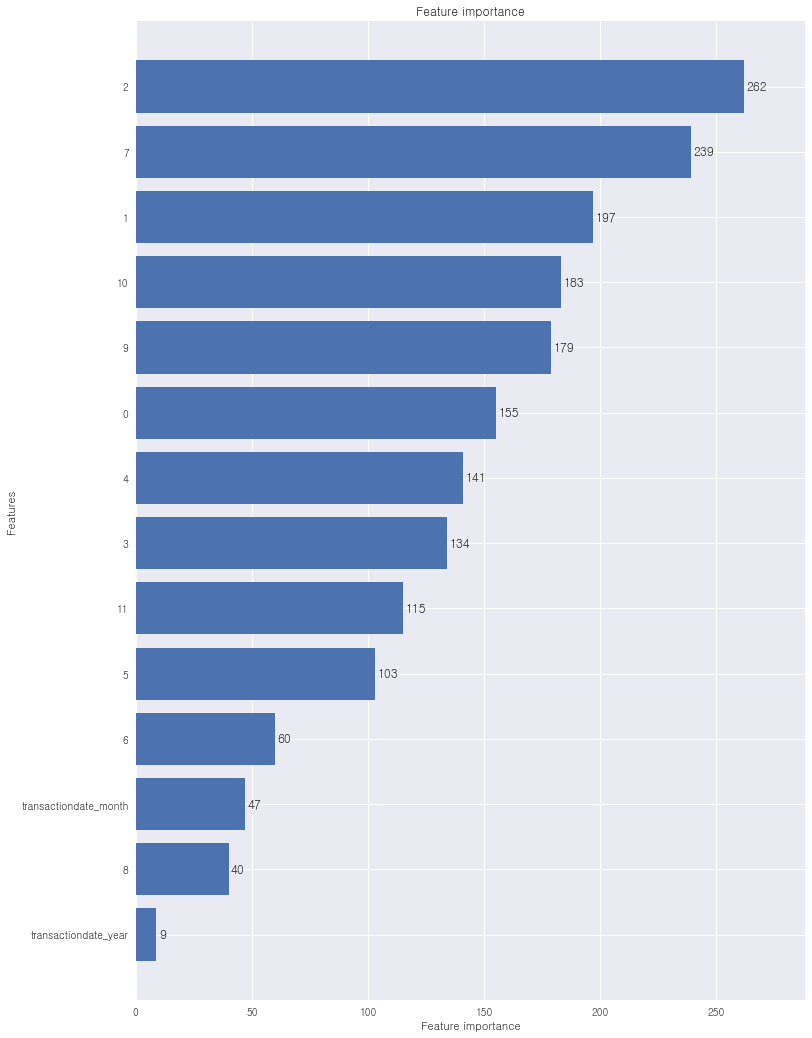

In [31]:
print("fscore result")
fscore_df = pd.concat([pd.DataFrame(bst.feature_name()),pd.DataFrame(bst.feature_importance())],axis=1)
fscore_df.columns = ['column','fscore']
fscore_df['fscore'] = fscore_df['fscore'].astype(int)
fscore_df.sort_values(by='fscore',ascending=False,inplace=True)
fscoe_output = 'fscore/ex_'+str(lgbm_ex_no)+'_lgbm_fscore_'+ str(lgbm_cv_score)+ '.csv'
fscore_df.to_csv(fscoe_output)

fig, ax = plt.subplots(figsize=(12,18))
lgbm.plot_importance(bst, height=0.8, ax=ax)
plt.show()

In [32]:
print("Predict")
sub = pd.read_csv('input/sample_submission.csv')
for c in sub.columns[sub.columns != 'ParcelId']:
    print(c)
    
    x_test['transactiondate_month'] = int(c[4:])
    x_test['transactiondate_year'] = int(c[:4])
    predictions = bst.predict(x_test)
        
    sub[c] = predictions

print("Wrting Files")
sub_output = 'output/ex_'+str(lgbm_ex_no)+'_lightgbm_'+str(lgbm_cv_score)
sub.to_csv(sub_output+'.csv', index=False, float_format='%.4f') # Thanks to @inversion

print("File Zip")
jungle_zip = zipfile.ZipFile(sub_output +'.zip', 'w')
jungle_zip.write(sub_output + '.csv', compress_type=zipfile.ZIP_DEFLATED)
 
jungle_zip.close()
print("Done")

Predict
201610
201611
201612
201710
201711
201712
Wrting Files
File Zip
Done
